In [1]:
import numpy as np
import pandas as pd
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'widget ')
import matplotlib.pyplot as plt

In [2]:
# Load decoded telemetry
df = pd.read_csv('data/40014.csv')

# Filter the email messages
print(df.shape)
# Remove rows with more than 80% of missing values (basically, remove the email messages)
df = df.dropna(thresh=0.2 * len(df.columns), axis=0)
# Remove columns with more than 90% of missing values
df = df.dropna(thresh=0.1 * len(df), axis=1)
print(df.shape)

# Remove duplicates
print(df.shape)
df = df.drop_duplicates(subset=['timestamp'])
print(df.shape)

# get timestamp and battery voltage
battery_voltage = df['nice_battery_mv'].values
UTC_time = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S', utc=True)
UNIX_time = UTC_time.astype('int64') // 10**9
UNIX_time = np.array(UNIX_time.values, dtype=np.int64)

(1014838, 48)
(926782, 48)
(926782, 48)
(906562, 48)


In [3]:
# Calculate the phase of each point
eclipse_file = 'data/eclipses_40014.csv'

df = pd.read_csv(eclipse_file, sep=",", skiprows=1, header=None, names=["Start Time (UTC)", "Stop Time (UTC)"])
df['Start Time (UTC)'] = pd.to_datetime(df['Start Time (UTC)'], format='%Y-%m-%dT%H:%M:%S.%f %Z', utc=True)
df['Stop Time (UTC)'] = pd.to_datetime(df['Stop Time (UTC)'], format='%Y-%m-%dT%H:%M:%S.%f %Z', utc=True)
df['Start Time (UNIX)'] = df['Start Time (UTC)'].astype('int64') // 10**9
df['Stop Time (UNIX)'] = df['Stop Time (UTC)'].astype('int64') // 10**9

# Basically, we have the start and end of eclipse.
# We want now to populate the time_s_start_event and time_s_end_event arrays with the start and end times of the eclipses, as well as the non-eclipse periods in between.
# We use eclipse_event_type to identify whether the event is an eclipse (1) or a non-eclipse (0).

time_s_start_event = np.zeros(int(len(df['Start Time (UNIX)']) * 2) - 1, dtype=np.int64)
time_s_end_event = np.zeros(int(len(df['Stop Time (UNIX)']) * 2) - 1, dtype=np.int64) 
eclipse_event_type = np.zeros(int(len(df['Stop Time (UNIX)']) * 2) - 1)
for i in range(0, len(df['Start Time (UNIX)']), 1):
    time_s_start_event[i*2] = df['Start Time (UNIX)'].iloc[i]
    time_s_end_event[i*2] = df['Stop Time (UNIX)'].iloc[i]
    eclipse_event_type[i*2] = 1

    if i + 1 != len(df['Start Time (UNIX)']):
        time_s_start_event[i*2+1] = df['Stop Time (UNIX)'].iloc[i]
        time_s_end_event[i*2+1] = df['Start Time (UNIX)'].iloc[i + 1]
        eclipse_event_type[i*2+1] = 0

del df

In [4]:
# Phase-fold calculation
data_point = []
for i in range(0, len(time_s_start_event)-1, 2):
    y_t = battery_voltage[(UNIX_time > time_s_start_event[i]) & (UNIX_time < time_s_end_event[i+1])] # get eclipse + illuminated data of 1 period
    x_t = UNIX_time[(UNIX_time > time_s_start_event[i]) & (UNIX_time < time_s_end_event[i+1])]
    period_length = time_s_end_event[i+1] - time_s_start_event[i]

    for j in range(len(y_t)):
        current_time = x_t[j] - time_s_start_event[i]   # current time of the point - time at the start of the period
        data_point.append([x_t[j], y_t[j], current_time, current_time/period_length, period_length, i]) # append, absolute time, battery voltage, phase, phase normalized, period length, period index


In [ ]:
# Filter the data to only include points within a certain time period (e.g., 2020-01-01 to 2021-01-01)
start_time = int(pd.Timestamp("2020-01-01").timestamp())
end_time = int(pd.Timestamp("2021-01-01").timestamp())   

data_point = np.array(data_point)
filtered_data = data_point[(data_point[:, 0] >= start_time) & (data_point[:, 0] <= end_time)]

x_t = filtered_data[:, 0]
y_t = filtered_data[:, 1]
time_period = filtered_data[:, 2]
phase = filtered_data[:, 3]
period_length = filtered_data[:, 4]
period_index = filtered_data[:, 5]

# For plotting a square wave with the current event type (eclipse or non-eclipse) 
eclipse_points_x = np.zeros(len(time_s_start_event) * 2, dtype=np.int64)
eclipse_points_y = np.zeros(len(time_s_end_event) * 2, dtype=np.int64)
for i in range(len(time_s_start_event)):
    if eclipse_event_type[i] == 0:
        eclipse_points_y[2 * i] = 0
        eclipse_points_y[2 * i + 1] = 0
    elif eclipse_event_type[i] == 1:
        eclipse_points_y[2 * i] = 1
        eclipse_points_y[2 * i + 1] = 1
    
    eclipse_points_x[2 * i] = time_s_start_event[i]
    eclipse_points_x[2 * i + 1] = time_s_end_event[i]

# Add an extra day worth of seconds to the start and end time for filtering eclipse points, to make sure we capture all points around the edges of the period.
start_time2 = start_time - 86400
end_time2 = end_time + 86400

# Filter the eclipse points to only include points within a certain time period
eclipse_points_y = eclipse_points_y[(eclipse_points_x >= start_time2) & (eclipse_points_x <= end_time2)]
eclipse_points_x = eclipse_points_x[(eclipse_points_x >= start_time2) & (eclipse_points_x <= end_time2)]

C:\Users\Fi\AppData\Local\Temp\ipykernel_2668\2110415861.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper left')


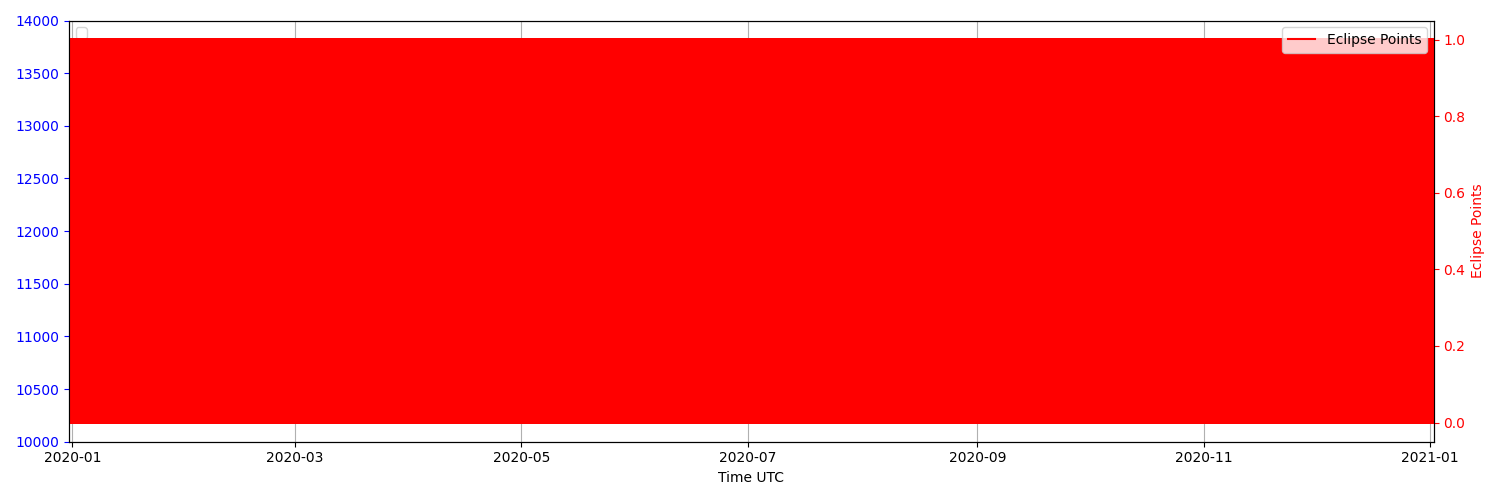

In [7]:
# Time series plot of battery voltage with eclipse/non-eclipse periods highlighted
fig, ax1 = plt.subplots(figsize=(15, 5))

ax1.scatter(UTC_time, battery_voltage, color='b', s=0.5)
ax1.set_xlabel('Time UTC')
ax1.tick_params('y', colors='b')
ax1.grid(True)
ax1.set_ylim(10000, 14000)
ax1.set_xlim(pd.to_datetime(start_time2, unit='s'), pd.to_datetime(end_time2, unit='s'))

ax2 = ax1.twinx()
ax2.plot(pd.to_datetime(eclipse_points_x, unit='s'), eclipse_points_y, label='Eclipse Points', color='r')
ax2.set_ylabel('Eclipse Points', color='r')
ax2.tick_params('y', colors='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_xlim(pd.to_datetime(start_time2, unit='s'), pd.to_datetime(end_time2, unit='s'))

plt.tight_layout()
plt.show()


In [ ]:
import scipy.io
# save the data. why in .mat format? because it's easier to load in MATLAB for plotting.
scipy.io.savemat('data/40014_dataset.mat', {
    'absolute_time': x_t,
    'value': y_t,
    'phase': time_period,
    'phase_normalized': phase,
    'period_length': period_length,
    'period_count': period_index,
    'eclipse_points_x': eclipse_points_x,
    'eclipse_points_y': eclipse_points_y
})